In [ ]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose(
            [transforms.ToTensor()]
        )

segmap_img_path = '/home/Lev/Projects/diffusion_finetuning/data/bin_seg_maps/2011_003271.jpg'
segmap_instance_image = Image.open(segmap_img_path)
segmap_instance_image = transform(segmap_instance_image)
print(torch.unique(segmap_instance_image))


In [71]:
%load_ext autoreload
%autoreload 2

In [8]:
from diffusers import StableDiffusionPipeline
model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda:3")

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 7102.22it/s]


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


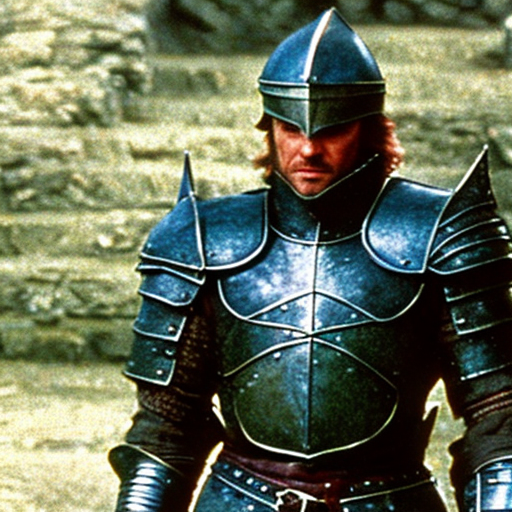

In [49]:
img = pipe(prompt='dvd screengrab, dark fantasy film from 1982 ,knight in armor, dragon',negative_prompt='weird, distorted', num_inference_steps=40).images[0]
img

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')
img = Image.open('/disk4/Lev/Projects/diffusion_finetuning/data/original_val/2007_000175.jpg').convert('RGB').resize([512,512])


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 6335.81it/s]


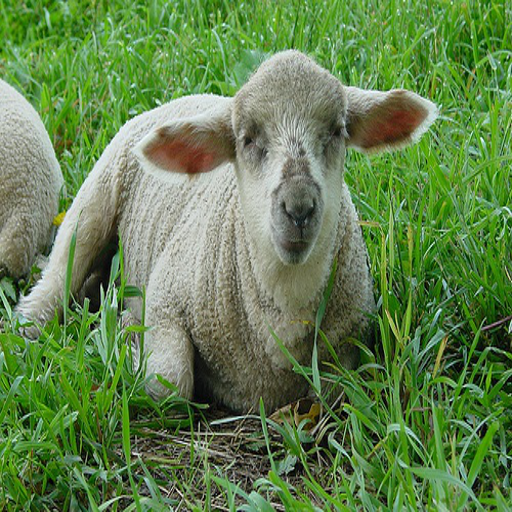

In [22]:
img

In [20]:
prompt = "black sheep"
diff_img = pipe(prompt=prompt, image=img, strength=0.7, guidance_scale=8).images[0]

100%|██████████| 35/35 [00:03<00:00, 11.46it/s]


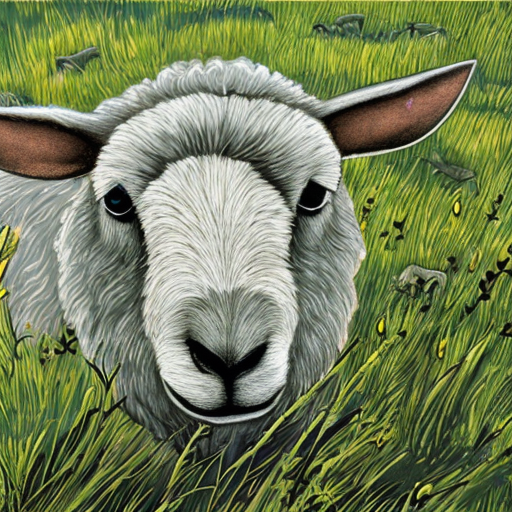

In [21]:
diff_img

### Test Segmentation Mask

In [14]:
import numpy as np

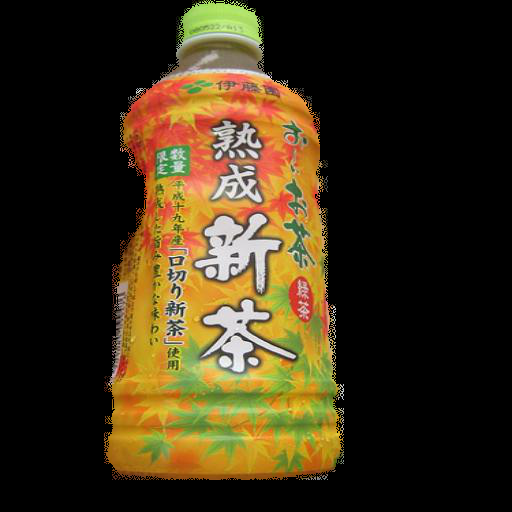

In [13]:
img = Image.open('./img.jpeg').convert('RGB').copy()
mask = Image.open('./segmap_img.jpeg').convert('RGB').copy()

img = np.asarray(img).copy()
mask = np.asarray(mask)
mask = np.all(mask == [0, 0, 0], axis=-1)

img[mask] = [0,0,0]
img = Image.fromarray(img).convert('RGB')
img

### Test VAE on LITS17 Dataset

In [16]:
from training_scripts.LITS17Dataset import LITS17Dataset
from transformers import CLIPTokenizer
#vae = pipe.vae.to('cuda:1')
# tokenizer = CLIPTokenizer.from_pretrained(
#             args.tokenizer_name,
#             revision=args.revision,
ct_dir = 
lits17ds = LITS17Dataset()

### Test VAE of Img2Img pipeline

torch.Size([1, 3, 512, 512])


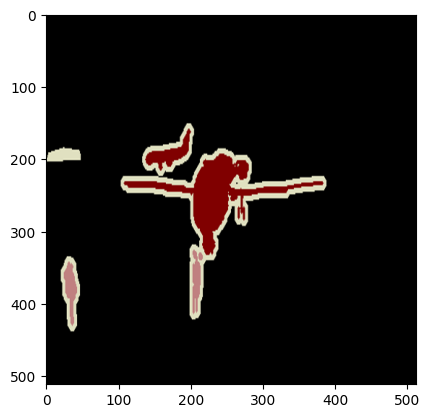

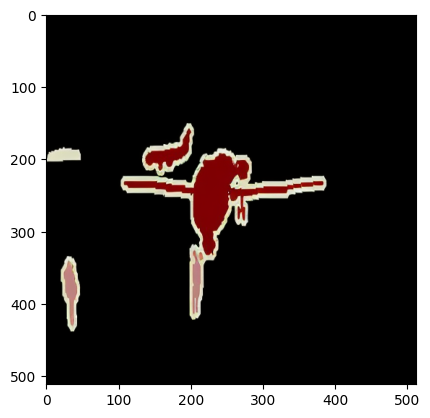

In [48]:
vae = pipe.vae.to('cuda:1')

img_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ]
)
plt.figure(1)
tst_img_path = "./data/seg_maps_class_train/2007_000032.png"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])
plt.imshow(tst_img)
tst_img = img_transforms(tst_img).to('cuda:1', dtype=torch.float16)
tst_img = tst_img.unsqueeze(0)
# tst_img = torch.stack(tst_img).to(memory_format=torch.contiguous_format).float()
print(tst_img.shape)

tst_img_latents = vae.encode(tst_img).latent_dist.sample()
tst_img_latents *= 0.18215
#decoded_img = vae.decode(tst_img_latents).sample.detach().cpu().squeeze()
decoded_img = decode_latents(vae, tst_img_latents).squeeze()
plt.figure(2)
plt.imshow(decoded_img)

In [47]:
def decode_latents(vae, latents):
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
        return image

### Test Trained UNET (for segmentation)

In [3]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits17/w_text/ct_liver_segmentation_run1/'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1.5)
tune_lora_scale(pipe.text_encoder, 1)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 9543.35it/s]


In [ ]:
## Testing LITS dataset


100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


decoding seg img


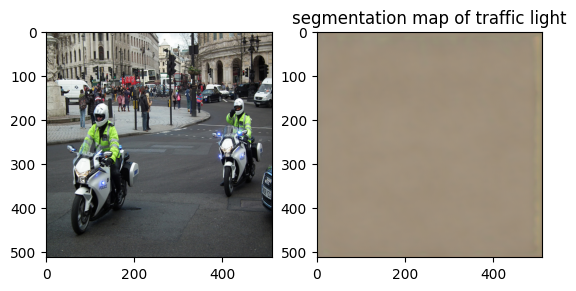

In [52]:
tst_img_path = "/disk4/Lev/Projects/diffusion_finetuning/data/cocostuff/images/COCO_train2014_000000576187.jpg"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])

fig, axs = plt.subplots(1,2)
axs[0].imshow(tst_img)

img_transforms = transforms.Compose([
    # transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.CenterCrop(512),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
    ]
)

tst_img = img_transforms(tst_img).to('cuda:3', dtype=torch.float16)
tst_img = tst_img.unsqueeze(0)

# tst_img = img_transforms(tst_img)
# print(tst_img.shape)
prompt="segmentation map of traffic light"
img = pipe(prompt=prompt, image=tst_img, strength=0.4, guidance_scale=10, modified_unet=True, segmentation=True).images[0]

axs[1].imshow(img)
axs[1].set_title(prompt)
plt.show()

In [ ]:

img[mask] = [0,0,0]
img = Image.fromarray(img).convert('RGB')
img

In [ ]:

img[mask] = [0,0,0]
img = Image.fromarray(img).convert('RGB')
img

100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.41it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.50it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.51it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.40it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.51it/s]


decoding seg img


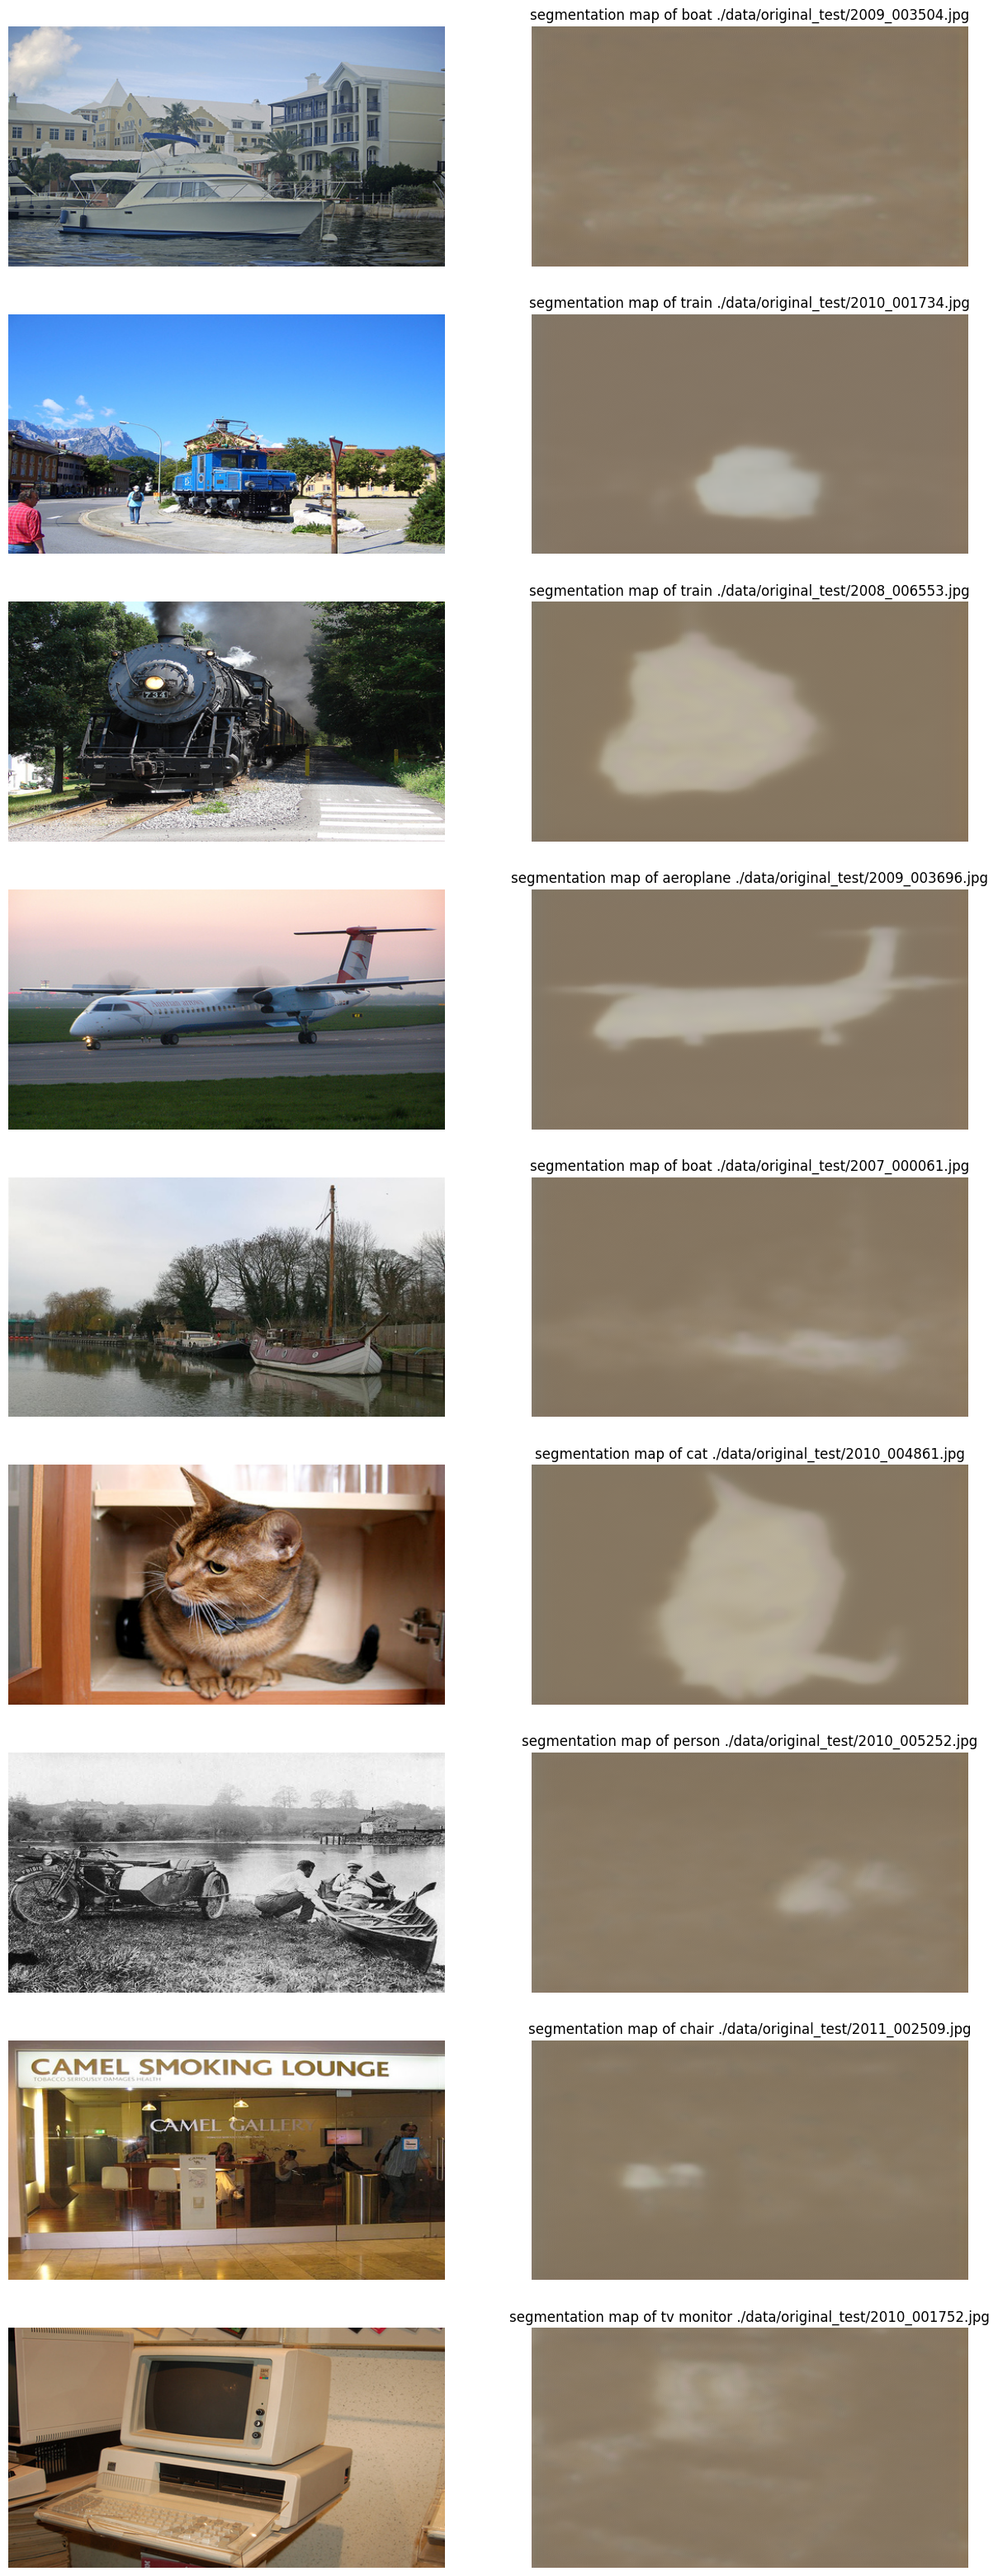

In [101]:
diffuse_random_imgs('./data/original_test/', pipe,"segmentation map of", 0.1, 12)

In [2]:
def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(15, 40))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()

